In [1]:
from sklearn.datasets.samples_generator import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

C:\Anaconda3\envs\nlpiaenv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# prepare the dataset
def prepare_data():
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, testX, trainy, testy

In [3]:
# define, fit and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
    
    # define model
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='linear'))

    # compile model
    model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))

    # fit model
    model.fit(trainX, trainX, epochs=100, verbose=0)
    # evaluate reconstruction loss
    train_mse = model.evaluate(trainX, trainX, verbose=0)
    test_mse = model.evaluate(testX, testX, verbose=0)
    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
    return model

In [4]:
# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
    
    # remember the current output layer
    output_layer = model.layers[-1]

    # remove the output layer
    model.pop()

    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False

    # add new output layer
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9),metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)
    # evaluate model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)

    # put the model back together
    model.pop()
    model.add(output_layer)
    model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
    return train_acc, test_acc

In [5]:
# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, trainX, testX):
    
    # remember the current output layer
    output_layer = model.layers[-1]

    # remove the output layer
    model.pop()

    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False

    # add a new hidden layer
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))

    # re-add the output layer
    model.add(output_layer)

    # fit model
    model.fit(trainX, trainX, epochs=100, verbose=0)

    # evaluate reconstruction loss
    train_mse = model.evaluate(trainX, trainX, verbose=0)
    test_mse = model.evaluate(testX, testX, verbose=0)
    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

In [6]:
# prepare data
trainX, testX, trainy, testy = prepare_data()

In [7]:
# get the base autoencoder
model = base_autoencoder(trainX, testX)

> reconstruction error train=0.000, test=0.000


In [8]:
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX,testy)
print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers),train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)

> classifier accuracy layers=2, train=0.840, test=0.834


In [9]:
# add layers and evaluate the updated model
n_layers = 5


for _ in range(n_layers):
    # add layer
    add_layer_to_autoencoder(model, trainX, testX)

    # evaluate model
    train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX,testy)
    print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers),train_acc, test_acc))
    
    # store scores for plotting
    scores[len(model.layers)] = (train_acc, test_acc)

> reconstruction error train=0.002, test=0.003
> classifier accuracy layers=3, train=0.832, test=0.836
> reconstruction error train=0.002, test=0.005
> classifier accuracy layers=4, train=0.824, test=0.830
> reconstruction error train=0.004, test=0.009
> classifier accuracy layers=5, train=0.826, test=0.832
> reconstruction error train=0.002, test=0.005
> classifier accuracy layers=6, train=0.816, test=0.838
> reconstruction error train=0.003, test=0.007
> classifier accuracy layers=7, train=0.820, test=0.840


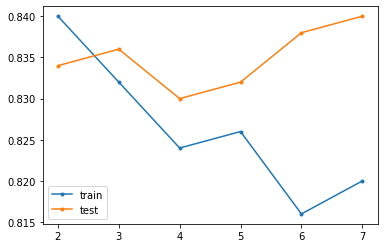

In [10]:
# plot number of added layers vs accuracy
keys = scores.keys()
pyplot.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
pyplot.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
pyplot.legend()
pyplot.show()